In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/adityajn105/flickr30k/captions.txt
/kaggle/input/datasets/adityajn105/flickr30k/Images/2715746315.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/3463034205.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/268704620.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/2673564214.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/7535037918.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/4912369161.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/4828071602.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/6802728196.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/3346289227.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/3217056901.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/272471327.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/4717261252.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/4763916790.jpg
/kaggle/input/datasets/adityajn105/flickr30k/Images/2700788458.jpg
/kaggl

In [16]:
!pip -q install nltk rouge-score gradio

In [17]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Feature Extraction using the given code:

In [18]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added.")

class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])  # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")


Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s] 
Extracting Features: 100%|██████████| 249/249 [01:58<00:00,  2.11it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


### Features generated successfully as *'flickr30k_features.pkl'*

# Loading Captions

In [37]:
import pandas as pd
import re
from collections import Counter

# Loading captions into a dataframe/list of (image_name, caption) pairs
rows = []
with open(CAPTIONS_PATH, "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        line = line.strip()
        if not line:
            continue
        # Check for common formats (CSV or Tab-separated)
        if "\t" in line:
            img, cap = line.split("\t", 1)
        elif "," in line:
            img, cap = line.split(",", 1)
        else:
            continue
        rows.append((img.strip(), cap.strip()))

# Create a DataFrame
df = pd.DataFrame(rows, columns=["image", "caption"])
df.head(), len(df)

(            image                                            caption
 0  1000092795.jpg  Two young guys with shaggy hair look at their ...
 1  1000092795.jpg  " Two young , White males are outside near man...
 2  1000092795.jpg   Two men in green shirts are standing in a yard .
 3  1000092795.jpg       A man in a blue shirt standing in a garden .
 4  1000092795.jpg            Two friends enjoy time spent together .,
 158915)

# Cleaning Captions
### Removing unwanted characters and making lowercase

In [38]:
# Clean captions by removing unwanted characters and making lowercase
def clean_caption(s: str) -> str:
    s = s.lower()  # Convert to lowercase
    s = re.sub(r"[^a-z0-9\s]", "", s)  # Remove punctuation
    s = re.sub(r"\s+", " ", s).strip()  # Normalize spaces
    return s

df["caption_clean"] = df["caption"].apply(clean_caption)

# View cleaned captions
df.head()

image                                            caption  \
0  1000092795.jpg  Two young guys with shaggy hair look at their ...   
1  1000092795.jpg  " Two young , White males are outside near man...   
2  1000092795.jpg   Two men in green shirts are standing in a yard .   
3  1000092795.jpg       A man in a blue shirt standing in a garden .   
4  1000092795.jpg            Two friends enjoy time spent together .   

                                       caption_clean  
0  two young guys with shaggy hair look at their ...  
1  two young white males are outside near many bu...  
2     two men in green shirts are standing in a yard  
3         a man in a blue shirt standing in a garden  
4              two friends enjoy time spent together

   # Build Vocab & Convert 'Captions → Token IDs'
   ### 1. Building vocabulary by counting word frequencies
   ### 2. Adding special tokens (<pad\>, <unk\>, <start\>, <end\>)
   ### 3. Converting captions to token IDs

In [39]:
# Special tokens
SPECIALS = ["<pad>", "<unk>", "<start>", "<end>"]
PAD, UNK, START, END = SPECIALS

# Count word frequencies
min_freq = 3  # You can change this if you want more/less common words

counter = Counter()
for cap in df["caption_clean"]:
    counter.update(cap.split())

# Filter words by frequency
vocab_words = [w for w, c in counter.items() if c >= min_freq]
vocab = SPECIALS + sorted(vocab_words)

# Create word-to-id and id-to-word mappings
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in word2idx.items()}

# Get special token IDs
pad_id = word2idx[PAD]
unk_id = word2idx[UNK]
start_id = word2idx[START]
end_id = word2idx[END]
vocab_size = len(vocab)

# Function to convert captions to token IDs
def encode_caption(cap: str):
    tokens = cap.split()
    ids = [start_id] + [word2idx.get(t, unk_id) for t in tokens] + [end_id]
    return ids

# Convert captions to token IDs
df["cap_ids"] = df["caption_clean"].apply(encode_caption)

# View the result
df[["image", "caption_clean", "cap_ids"]].head()

image                                      caption_clean  \
0  1000092795.jpg  two young guys with shaggy hair look at their ...   
1  1000092795.jpg  two young white males are outside near many bu...   
2  1000092795.jpg     two men in green shirts are standing in a yard   
3  1000092795.jpg         a man in a blue shirt standing in a garden   
4  1000092795.jpg              two friends enjoy time spent together   

                                             cap_ids  
0  [2, 9348, 10000, 3933, 9884, 7663, 3949, 5093,...  
1  [2, 9348, 10000, 9801, 5195, 387, 5962, 5671, ...  
2  [2, 9348, 5356, 4394, 3846, 7736, 387, 8366, 4...  
3  [2, 71, 5203, 4394, 71, 956, 7733, 8366, 4394,...  
4            [2, 9348, 3550, 2962, 9031, 1, 9063, 3]

# Choosing *Max Length* + *Padding*

In [40]:
import numpy as np

lengths = df["cap_ids"].apply(len).values
max_len = int(np.percentile(lengths, 95))  # stable choice
max_len = max(max_len, 10)
print("Chosen max_len:", max_len)

def pad_to_max(ids, max_len):
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids = ids + [pad_id] * (max_len - len(ids))
    return ids

df["cap_ids_pad"] = df["cap_ids"].apply(lambda x: pad_to_max(x, max_len))

Chosen max_len: 24


# Splitting into (train/val/test) by image 
### To avoid leakage

In [41]:
from sklearn.model_selection import train_test_split

unique_images = df["image"].unique()

train_imgs, test_imgs = train_test_split(unique_images, test_size=0.1, random_state=42)
train_imgs, val_imgs  = train_test_split(train_imgs, test_size=0.1, random_state=42)

train_df = df[df["image"].isin(train_imgs)].reset_index(drop=True)
val_df   = df[df["image"].isin(val_imgs)].reset_index(drop=True)
test_df  = df[df["image"].isin(test_imgs)].reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(128715, 14305, 15895)

# Building Dataset/DataLoader using cached *.pkl* features

In [42]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

with open("flickr30k_features.pkl", "rb") as f:
    features = pickle.load(f)

class CaptionDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = row["image"]
        cap = torch.tensor(row["cap_ids_pad"], dtype=torch.long)

        # inputs and targets (teacher forcing)
        cap_in  = cap[:-1]
        cap_out = cap[1:]

        img_feat = torch.tensor(features[img], dtype=torch.float32)  # (2048,)
        return img_feat, cap_in, cap_out, img

batch_size = 128

train_loader = DataLoader(CaptionDataset(train_df), batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(CaptionDataset(val_df), batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(CaptionDataset(test_df), batch_size=batch_size, shuffle=False, num_workers=2)

# Building Seq2Seq ⇒ **Encoder:** *Linear* + **Decoder:** *LSTM/GRU*
### **Encoder:** Linear 2048 → hidden_size
### **Decoder:** LSTM/GRU with embeddings ⇢ init hidden from encoder ⇢ output linear to vocab

In [43]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()
        self.fc = nn.Linear(2048, hidden_size)

    def forward(self, img_feat):
        # img_feat: (B, 2048)
        h0 = torch.tanh(self.fc(img_feat))  # (B, hidden)
        return h0

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_size=512, rnn_type="lstm"):
        super().__init__()
        self.rnn_type = rnn_type.lower()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)

        if self.rnn_type == "gru":
            self.rnn = nn.GRU(embed_dim, hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_size, batch_first=True)

        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, cap_in, h0):
        # cap_in: (B, T)
        x = self.embed(cap_in)  # (B, T, E)

        if self.rnn_type == "gru":
            # GRU needs (num_layers, B, hidden)
            out, hn = self.rnn(x, h0.unsqueeze(0))
        else:
            # LSTM needs (h0, c0)
            c0 = torch.zeros_like(h0).unsqueeze(0)
            out, (hn, cn) = self.rnn(x, (h0.unsqueeze(0), c0))

        logits = self.fc_out(out)  # (B, T, vocab)
        return logits

class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_size=512, rnn_type="lstm"):
        super().__init__()
        self.encoder = Encoder(hidden_size=hidden_size)
        self.decoder = Decoder(vocab_size, embed_dim=embed_dim, hidden_size=hidden_size, rnn_type=rnn_type)

    def forward(self, img_feat, cap_in):
        h0 = self.encoder(img_feat)
        logits = self.decoder(cap_in, h0)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(vocab_size=vocab_size, embed_dim=256, hidden_size=512, rnn_type="lstm").to(device)

# Training with CrossEntropy + Adam
### 1. Ignoring pad in CrossEntropy as asked in the assignment
### 2. Using Adam Opitmizer

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    losses = []

    for img_feat, cap_in, cap_out, _ in tqdm(loader, leave=False):
        img_feat = img_feat.to(device)
        cap_in   = cap_in.to(device)
        cap_out  = cap_out.to(device)

        with torch.set_grad_enabled(train):
            logits = model(img_feat, cap_in)  # (B, T, V)
            B, T, V = logits.shape
            loss = criterion(logits.reshape(B*T, V), cap_out.reshape(B*T))

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        losses.append(loss.item())

    return float(np.mean(losses))

train_losses, val_losses = [], []
best_val = 1e9

epochs = 5  # raise to 10+ if you want better quality
for ep in range(1, epochs+1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader, train=False)
    train_losses.append(tr)
    val_losses.append(va)

    print(f"Epoch {ep}/{epochs} | train_loss={tr:.4f} | val_loss={va:.4f}")

    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), "best_model.pt")

print("Saved best_model.pt")

Epoch 1/5 | train_loss=3.9344 | val_loss=3.4379


Epoch 2/5 | train_loss=3.1888 | val_loss=3.1754


Epoch 3/5 | train_loss=2.9047 | val_loss=3.0767


Epoch 4/5 | train_loss=2.7059 | val_loss=3.0378


Epoch 5/5 | train_loss=2.5460 | val_loss=3.0324
Saved best_model.pt


# Plotting lost curve

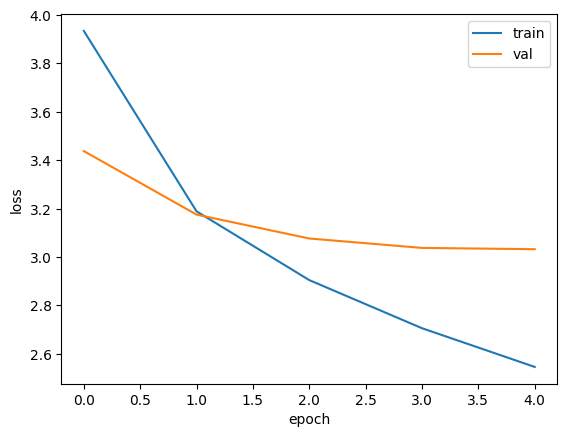

In [45]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# Inference → Greedy Search + Beam Search
## Greedy Search
### ➥ selects the most likely next word in each timestep.

In [48]:
@torch.no_grad()
def greedy_decode(img_feat_2048, max_len=30):
    # Move image feature to the device
    img_feat = torch.tensor(img_feat_2048, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 2048)
    
    # Get the initial hidden state from the encoder
    h0 = model.encoder(img_feat)  # (1, hidden_size)

    # Start token (used as the first word in the sequence)
    cur = torch.tensor([[start_id]], dtype=torch.long).to(device)  # (1, 1)
    out_tokens = []

    # Generate tokens up to max_len or until <end> token is produced
    for _ in range(max_len):
        logits = model.decoder(cur, h0)  # (1, T, V) where T is time steps and V is vocabulary size
        next_id = int(torch.argmax(logits[0, -1]).item())  # Get the next token ID (argmax)
        
        if next_id == end_id:  # Stop if <end> token is predicted
            break
        
        out_tokens.append(next_id)
        cur = torch.cat([cur, torch.tensor([[next_id]], device=device)], dim=1)  # Update input with the predicted token

    # Convert token IDs to words
    words = [idx2word.get(i, UNK) for i in out_tokens]
    return " ".join(words)  # Return the generated caption as a string

## Beam Search
### ➥ maintains multiple hypotheses (sequences) at each step and selects the top-k most probable sequences.

In [50]:
@torch.no_grad()
def beam_decode(img_feat_2048, beam_width=3, max_len=30):
    # Move image feature to the device
    img_feat = torch.tensor(img_feat_2048, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 2048)
    
    # Get the initial hidden state from the encoder
    h0 = model.encoder(img_feat)  # (1, hidden_size)

    # Initialize the beam with the start token and score 0
    beams = [([start_id], 0.0)]  # List of (sequence, score) tuples
    finished = []

    # Generate tokens up to max_len or until <end> token is produced
    for _ in range(max_len):
        new_beams = []
        
        # Expand each beam
        for seq, score in beams:
            if seq[-1] == end_id:  # If <end> token is generated, add to finished list
                finished.append((seq, score))
                continue

            cur = torch.tensor([seq], dtype=torch.long).to(device)  # Current sequence (input to decoder)
            logits = model.decoder(cur, h0)  # (1, T, V)
            log_probs = torch.log_softmax(logits[0, -1], dim=-1)  # Get log probabilities for the next token

            topk = torch.topk(log_probs, beam_width)  # Get top-k most probable tokens
            for k in range(beam_width):
                next_id = int(topk.indices[k].item())
                next_score = float(topk.values[k].item())
                new_beams.append((seq + [next_id], score + next_score))  # Add new beam with updated sequence

        # Sort and keep only the top-k beams
        new_beams.sort(key=lambda x: x[1], reverse=True)  # Sort by score (probability)
        beams = new_beams[:beam_width]  # Keep only the top-k beams

    # Add finished beams to the list
    finished.extend(beams)
    finished.sort(key=lambda x: x[1], reverse=True)  # Sort finished beams by score

    # Take the best beam (highest score)
    best_seq = finished[0][0]

    # Remove <start> and <end> tokens and convert to words
    best_seq = [t for t in best_seq if t not in (start_id, end_id, pad_id)]
    words = [idx2word.get(i, UNK) for i in best_seq]
    return " ".join(words)  # Return the best generated caption as a string

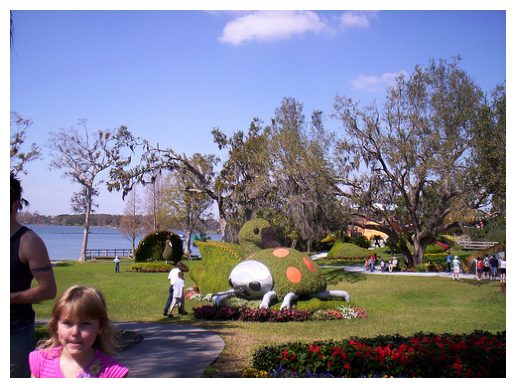

IMAGE: 3525568835.jpg
Ground Truth Caption: a little girl with blondhair wearing a pink shirt walks away from a topiary garden where a hedge has been cut to look like a ladybug
Predicted Caption (Greedy): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Predicted Caption (Beam): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------------------------------------


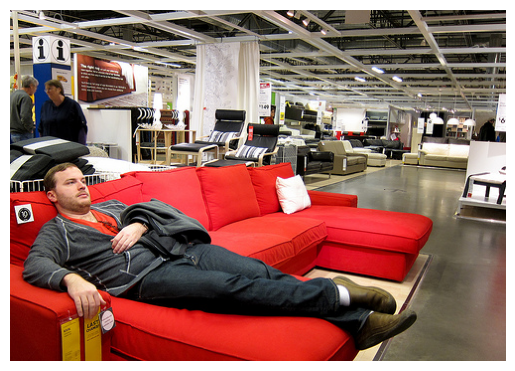

IMAGE: 6897514777.jpg
Ground Truth Caption: a man tired on a couch just waiting to go home from work
Predicted Caption (Greedy): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Predicted Caption (Beam): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------------------------------------


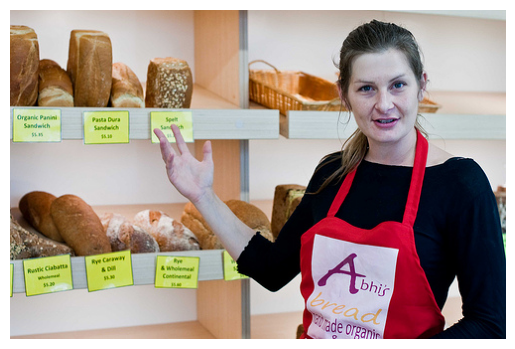

IMAGE: 7088933987.jpg
Ground Truth Caption: a woman in a red apron and black shirt holds her hand up and different types of bread are in the background
Predicted Caption (Greedy): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Predicted Caption (Beam): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------------------------------------


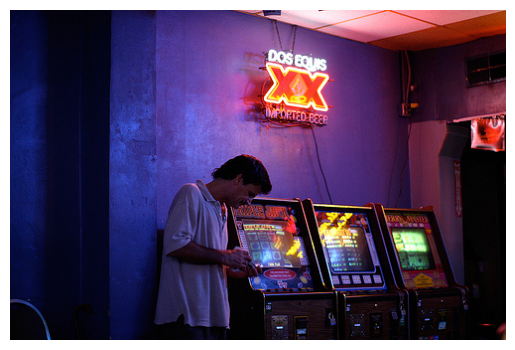

IMAGE: 1167908324.jpg
Ground Truth Caption: a man standing in a bar with a neon beer sign hanging on the wall
Predicted Caption (Greedy): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Predicted Caption (Beam): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------------------------------------


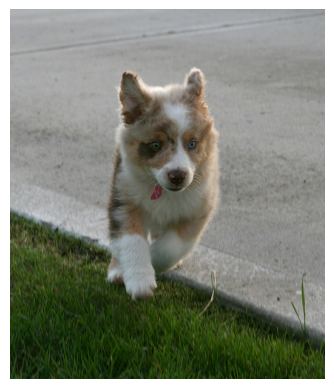

IMAGE: 2555535057.jpg
Ground Truth Caption: a beige white and black little dog is bounding towards the camera from the street onto the green grass
Predicted Caption (Greedy): <unk> <unk> <unk> <unk> <unk> <unk>
Predicted Caption (Beam): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------------------------------------


In [51]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Select 5 random images from the test set
sample_images = random.sample(list(test_imgs), 5)

for img_name in sample_images:
    # Load image
    img_path = os.path.join(IMAGE_DIR, img_name)  # Update with correct image folder path
    img = Image.open(img_path).convert("RGB")
    
    # Ground truth caption(s)
    gt_row = test_df[test_df["image"] == img_name].iloc[0]
    gt_caption = gt_row["caption_clean"]
    
    # Generate captions using Greedy and Beam Search
    pred_greedy = greedy_decode(features[img_name])
    pred_beam = beam_decode(features[img_name], beam_width=3)
    
    # Plot the image
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Display the captions
    print(f"IMAGE: {img_name}")
    print(f"Ground Truth Caption: {gt_caption}")
    print(f"Predicted Caption (Greedy): {pred_greedy}")
    print(f"Predicted Caption (Beam): {pred_beam}")
    print("-" * 80)

In [53]:
print("Vocabulary size:", vocab_size)


Vocabulary size: 10029
